In [1]:
import matplotlib.pyplot as plt

# plt.style.available
plt.style.use('seaborn-ticks')
plt.rcParams['font.family'] = 'Times New Roman'
# plt.rcParams['font.serif'] = 'Ubuntu'
# plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 16
# plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 10
markers = ('o', 's', 'v', '^', '<', '>', '8', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
colors = ('r', 'b', 'g', 'purple', 'orange', 'cyan')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import json
from os.path import join
import random
import numpy as np
from datetime import datetime
import multiprocessing as mp
from munch import munchify

import models
from utils import cycle_loader, get_grads, get_param
from data import get_dataloader
from custom_hurst import compute_Hc




seed='1'
lr='0.01'
bs = 64
for arch in ['resnet18']:
    for dataset in ['cifar10']: 
        for bs in [64, 128, 192, 256, 320, 384, 448, 512]:
            print('----arch={}----dataset={}----bs={}----'.format(arch, dataset, bs))
            dir = f'./runs_bs/{arch}/{dataset}/lr={lr}_bs={bs}_{seed}'
            with open(join(dir, 'config.json')) as f:
                args = munchify(json.loads(f.read()))
            args.device = torch.device(f"cuda:{args.gpu_id}" if torch.cuda.is_available() else "cpu")

            torch.manual_seed(args.seed)
            torch.cuda.manual_seed(args.seed)
            np.random.seed(args.seed)
            random.seed(args.seed)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

            train_loader, test_loader, num_classes = get_dataloader(args)
            args.num_classes = num_classes

            if not hasattr(models, args.arch):
                raise NotImplementedError(f'{args.arch} is not implemented now!!')
            else:
                model_class = getattr(models, args.arch)
            if args.arch == 'fc':
                if args.dataset == 'mnist':
                    model = model_class(num_classes=args.num_classes, width=args.width, depth=args.depth).to(args.device)
                elif args.dataset == 'cifar10':
                    model = model_class(input_dim=32*32*3, num_classes=args.num_classes, width=args.width, depth=args.depth).to(args.device)
            elif args.arch == 'alexnet':
                model = model_class(num_classes=args.num_classes, ch=args.scale).to(args.device)
            else:
                model = model_class(num_classes=args.num_classes).to(args.device)

            logger = torch.load(join(dir, 'logger.pt'))

            res_hurst = []
            for r in range(3):
                model.load_state_dict(torch.load(join(dir, 'model.pt')), strict=True)
                optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
                model.train()
                cycle_train_loader_sample = cycle_loader(train_loader)
                loss_function = nn.functional.cross_entropy
                _, tot_param = get_param(model)
                args.rnd_dim = 50000
                args.num_noise = 1000
                if tot_param < args.rnd_dim:
                    args.rnd_dim = tot_param
                ids = torch.randperm(tot_param)[:args.rnd_dim]
                grads = []
                for j, (data, target) in enumerate(cycle_train_loader_sample):
                    if j == args.num_noise:
                        break
                    optimizer.zero_grad()
                    data, target = data.to(args.device), target.to(args.device)
                    output = model(data)
                    loss = loss_function(output, target)
                    loss.backward()
                    grad = get_grads(model)
                    grads.append(grad.cpu()[ids])
                noise = torch.stack(grads)
                # calculate Hurst index for current step
                start_t = datetime.now()
                if noise.is_cuda:
                    noise = noise.cpu()
                noise = noise.double().numpy()
                noise = noise[:, ~np.isnan(noise).any(axis=0)] # delete unvalid elements in case of nan
                # here we exploit a parallel trick to accerlate the process
                global get_hurst
                def get_hurst(j):
                    h = compute_Hc(noise[:, j], kind='random_walk')
                    return h
                pool = mp.Pool(os.cpu_count())
                res = [pool.apply_async(get_hurst, args=(j,)) for j in range(noise.shape[1])]
                res = [p.get() for p in res]
                pool.close()
                pool.join()
                res = np.array(res)
                res = res[res>0.0]
                res = res[res<1.0]
                
                hurst_index = np.mean(res)
                res_hurst.append(hurst_index)
                end_t = datetime.now()
                elapsed_sec = (end_t - start_t).total_seconds()
                print("Hurst: {:.4f}, time elapsed: {:.2f} seconds".format(hurst_index, elapsed_sec))
            logger.hurst = np.mean(res_hurst)
            torch.save(logger, join(dir, 'logger.pt'))

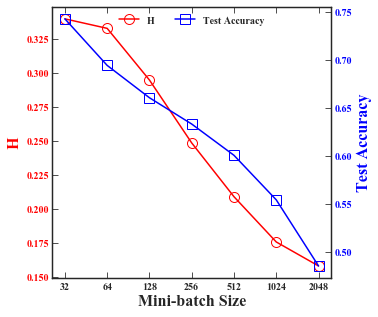

In [21]:
seed='1'
model='resnet18'
dataset='cifar10'
num_classes='10'
lr='0.01'
bs='64'
scale = '128'
res_hurst = []
res_acc = []
batch_sizes = [32, 64, 128, 256, 512, 1024, 2048]
for bs in batch_sizes:
    dir = f'./runs_bs/{model}/{dataset}/lr={lr}_bs={bs}_{seed}'
    logger = torch.load(join(dir, 'logger.pt'))
    res_hurst.append(logger.hurst)
    res_acc.append(np.max(logger.test_acc))

fig, ax = plt.subplots(figsize=(5, 5))

xticks = list(range(len(batch_sizes)))
xticks_labels = batch_sizes
ax.set_xticks(xticks)
ax.set_xticklabels(xticks_labels, minor=False)
ax.set_xlabel('Mini-batch Size')
ax.set_ylabel('H', color='r')
ax.tick_params(axis='y', labelcolor='r')
line1 = ax.plot(xticks, res_hurst, label='H', marker='o', markersize=10, fillstyle='none', color='r')

ax1 = ax.twinx()

ax1.set_ylabel('Test Accuracy', color='b')
ax1.tick_params(axis='y', labelcolor='b')

line2 = ax1.plot(xticks, res_acc, label='Test Accuracy', marker='s', markersize=10, fillstyle='none', color='b')


lines = line1 + line2 
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='upper center', ncol=2, frameon=False, edgecolor='k')
ax.tick_params(axis='both', which='both', direction='in', top=True, bottom=True, left=True, right=False, labelleft=True, labelbottom=True)
ax1.tick_params(axis='both', which='both', direction='in', top=False, bottom=False, left=False, right=True, labelleft=False, labelbottom=True)
plt.savefig('./figures/{}_bs_{}.eps'.format(arch, dataset), format='eps', bbox_inches='tight')